In [1]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
import plotly.graph_objects as go

df = pd.read_csv(r"C:\Users\MadiL\Thesis CodeBase\Cross-Sectional\LSAS_together.csv")

### Correlation Matrix

In [2]:
lsas_columns = [col for col in df.columns if "LSAS" in col]
cfs_columns = [col for col in df.columns if "CFS" in col]
bdi_columns = [col for col in df.columns if "BDI" in col]

# Subset the dataframe
### If we want to use demographics, don't subset
df_subset = df[lsas_columns + cfs_columns + bdi_columns].copy()


# Reverse score CFS questions 2, 3, 5, 10 in place
reverse_columns = ['CFS_2', 'CFS_3', 'CFS_5', 'CFS_10']

# Apply the reverse scoring transformation in place
df_subset[reverse_columns] = 7 - df_subset[reverse_columns]

# Reverse the direction of all CFS columns by multiplying by -1
df_subset[cfs_columns] = df_subset[cfs_columns] * -1


# Now df_subset has the reverse scored columns in place


# Normalize LSAS (all questions, range 0-3), CFS (range 1-6), and BDI (range 0-3)
def normalize(df, min_val, max_val):
    return (df - min_val) / (max_val - min_val)

# Normalize all LSAS columns (range 0-3)
df_subset[lsas_columns] = normalize(df_subset[lsas_columns], 0, 3)

# Normalize CFS columns (range 1-6)
df_subset[cfs_columns] = normalize(df_subset[cfs_columns], 1, 6)

# Normalize BDI columns (range 0-3)
df_subset[bdi_columns] = normalize(df_subset[bdi_columns], 0, 3)

# Sum all normalized LSAS items (no fear/avoidance separation) into one total score
df_subset['LSAS_Total'] = df_subset[lsas_columns].sum(axis=1)

# Sum normalized CFS and BDI scores
df_subset['CFS_Total'] = df_subset[cfs_columns].sum(axis=1)
df_subset['BDI_Total'] = df_subset[bdi_columns].sum(axis=1)

# Create a new DataFrame with the normalized total scores
df_total_scores = df_subset[['LSAS_Total', 'CFS_Total', 'BDI_Total']]

# Display the first few rows to check the normalized total scores
print(df_total_scores.head())

# Compute the correlation matrix on the normalized total scores
correlation_matrix = df_total_scores.corr()

# Print the correlation matrix
print(correlation_matrix)



   LSAS_Total  CFS_Total  BDI_Total
0    2.333333       -9.2        2.0
1    0.000000      -14.0        0.0
2    9.000000       -9.2       12.0
3   32.666667      -14.0        0.0
4   21.666667      -11.8        0.0
            LSAS_Total  CFS_Total  BDI_Total
LSAS_Total    1.000000   0.544973   0.509323
CFS_Total     0.544973   1.000000   0.520339
BDI_Total     0.509323   0.520339   1.000000


### Building a Network

In [3]:
import numpy as np
import networkx as nx

# Set a correlation threshold to define a "strong" connection
threshold = 0.4

# Initialize an empty graph
G = nx.Graph()

# Add all nodes to the graph, even if they don't have strong correlations
for col in correlation_matrix.columns:
    G.add_node(col)

# Add edges for pairs of questions that have a correlation above the threshold
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if np.abs(correlation_matrix.iloc[i, j]) > threshold:
            G.add_edge(correlation_matrix.columns[i], correlation_matrix.columns[j],
                       weight=correlation_matrix.iloc[i, j])

# Number of nodes in the graph
print(f"Number of nodes: {G.number_of_nodes()}")

# Number of edges in the graph
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 3
Number of edges: 3


This loop goes through every pair of questions in your dataset:

i and j represent the indices of two different questions (columns) in the correlation matrix.
The if statement checks whether the absolute value of the correlation between these two questions is greater than the threshold you set (0.3).

If the correlation is strong enough, an edge is added to the graph, connecting the two questions.
Why It’s Important: This step is how you build your network. Each edge in the network represents a significant relationship between two symptoms. The weight of the edge is the correlation value, which can be useful if you want to consider the strength of the connections in later analysis. 

### Analyze the Network

Identify Central Symptoms: Find out which questions (symptoms) are most central or influential in the network using measures like degree centrality.

Detect Clusters: Look for clusters or communities of symptoms that are closely connected, which might indicate groups of symptoms that co-occur or influence each other.


In [4]:
# Centrality analysis
centrality = nx.degree_centrality(G)
print("Most central symptoms:", sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10])

# Community detection
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print("Detected communities:", [list(c) for c in communities])

Most central symptoms: [('LSAS_Total', 1.0), ('CFS_Total', 1.0), ('BDI_Total', 1.0)]
Detected communities: [['CFS_Total', 'LSAS_Total', 'BDI_Total']]


### Visualize the Network

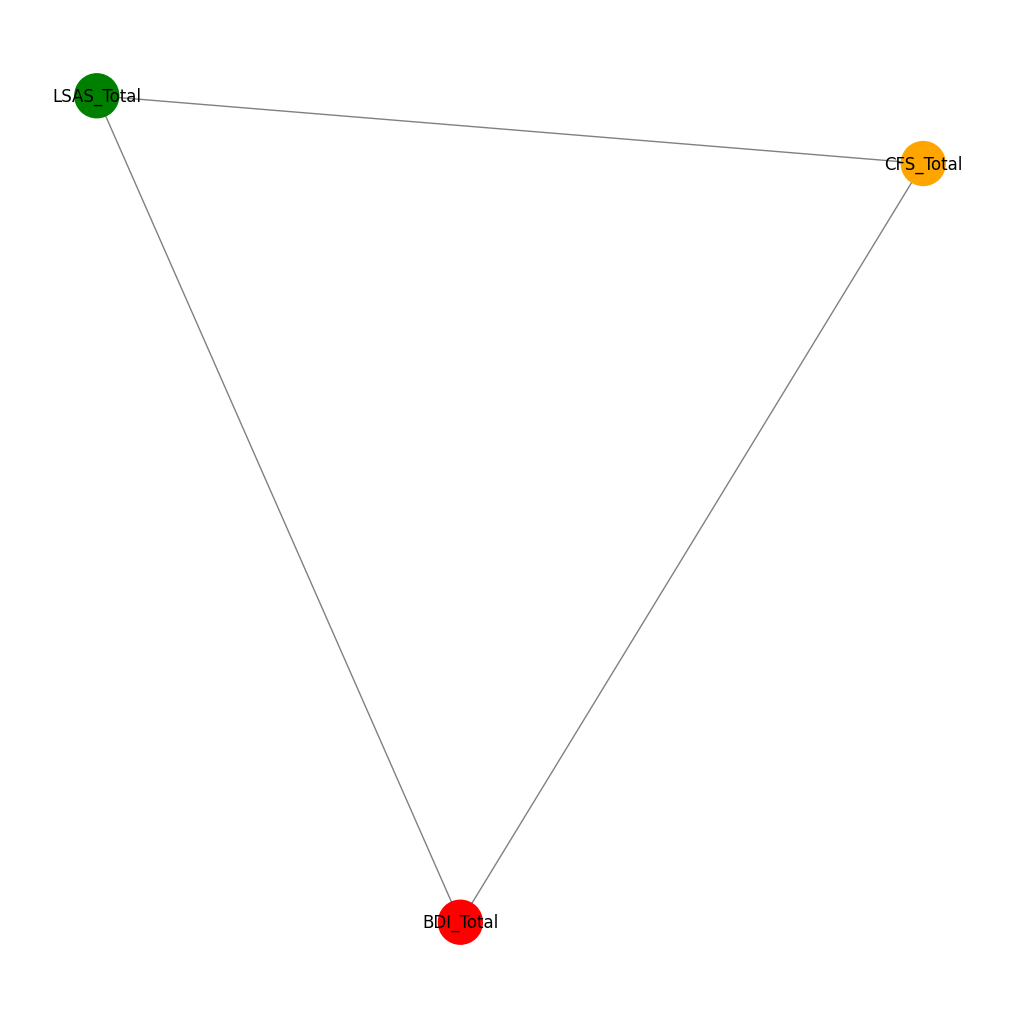

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Define a function to color nodes based on their survey type
def get_node_color(node):
    if "LSAS" in node:
        return 'green'
    elif "CFS" in node:
        return 'orange'
    elif "BDI" in node:
        return 'red'
    else:
        return 'gray'  # Default color for unrecognized nodes

# Assign colors to nodes based on their labels
node_colors = [get_node_color(node) for node in G.nodes]

# Define node positions using spring layout
pos = nx.spring_layout(G)  # You can also try other layouts like nx.circular_layout(G)

# Create the plot
plt.figure(figsize=(10, 10))

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, edge_color='gray')

# Show the plot
plt.show()


### Most/Least Connected Nodes

Shows nodes (questions) with the most and least degrees (number of connected edges)

In [6]:
import networkx as nx

# Assuming G is your graph from the previous steps

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find the most connected question(s)
most_connected = max(degree_dict, key=degree_dict.get)
most_connected_degree = degree_dict[most_connected]

# Find the least connected question(s)
least_connected = min(degree_dict, key=degree_dict.get)
least_connected_degree = degree_dict[least_connected]

# Print the results
print(f"Most connected question: {most_connected}: degree {most_connected_degree}")
print(f"Least connected question: {least_connected}: degree {least_connected_degree}")

# Sort nodes by their degree in descending order
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Print the results
print("Questions and their degrees (from highest to lowest):")
for question, degree in sorted_degree:
    print(f"{question}: {degree}")




Most connected question: LSAS_Total: degree 2
Least connected question: LSAS_Total: degree 2
Questions and their degrees (from highest to lowest):
LSAS_Total: 2
CFS_Total: 2
BDI_Total: 2


In [7]:
import pandas as pd
import numpy as np

# Assuming correlation_matrix is your DataFrame with correlations

# Set the diagonal elements to NaN to avoid self-pairing
np.fill_diagonal(correlation_matrix.values, np.nan)

# Find the maximum correlation value in the matrix
max_corr = correlation_matrix.max().max()

# Find the minimum correlation value in the matrix
min_corr = correlation_matrix.min().min()

# Find the pairs with the maximum correlation
max_corr_pairs = np.where(correlation_matrix == max_corr)
max_corr_questions = list(zip(correlation_matrix.columns[max_corr_pairs[0]], correlation_matrix.columns[max_corr_pairs[1]]))

# Find the pairs with the minimum correlation
min_corr_pairs = np.where(correlation_matrix == min_corr)
min_corr_questions = list(zip(correlation_matrix.columns[min_corr_pairs[0]], correlation_matrix.columns[min_corr_pairs[1]]))

# Print the results
print(f"Maximum correlation value: {max_corr}")
print("Pairs with the maximum correlation:")
for pair in max_corr_questions:
    print(f"{pair[0]} and {pair[1]}")

print(f"\nMinimum correlation value: {min_corr}")
print("Pairs with the minimum correlation:")
for pair in min_corr_questions:
    print(f"{pair[0]} and {pair[1]}")



Maximum correlation value: 0.5449728141288084
Pairs with the maximum correlation:
LSAS_Total and CFS_Total
CFS_Total and LSAS_Total

Minimum correlation value: 0.5093225935022909
Pairs with the minimum correlation:
LSAS_Total and BDI_Total
BDI_Total and LSAS_Total


# Next steps: 

Find out how to stratify by type of test, so that I can see highest correlations between items of different tests. RIght now we're just getting the avoidance/fear equivalent questions from the LSAS. Also don't make it say the pair backwards.